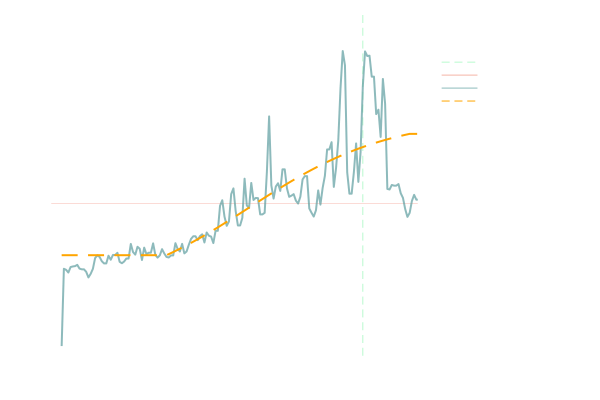

In [5]:
using HDF5, EzXML, Glob, Dates, Plots, Optim, LineSearches, LsqFit, JuMP, BayesOpt, DSP
import NLopt
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

datapath = "/Users/jjc/Documents/SSC/recs_june_2022"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

Ib_lower = 0.01
Ib_upper = 1.0
κ = 2
C = 10^3

function ferr(x)
    err = 0.0
    Rcsf = x[1]
    E = x[2]
    P_0 = x[3]
    ΔP = P_b - P_0
    I_b = ΔP / Rcsf
    It = I_b + I_inf
    for i = 1:length(Pm)
        tᵢ = (i - 1) / 6
        Pᵢ = It * ΔP / ( I_b + I_inf * exp( -E * It * tᵢ) ) + P_0
        err += (Pm[i] - Pᵢ)^2
    end
    δlb = delta.(Ib_lower .- I_b)
    δub = delta.(I_b .- Ib_upper)
    # δlb = -log(I_b - Ib_lower)
    # δub = -log(Ib_upper - I_b)
    δ = C .* vcat(δlb, δub) 
    penalty = sum(δ .^ κ)
    return err + penalty
end

for f = 1:length(files)
    filename = files[f]
    Data = readCSF(filename)

    global T = Data["T"]
    global rec_dur_s = Data["rec_dur_s"]
    global start_time = Data["start_time"]
    global end_time = Data["end_time"]
    global infusion_start_frame = Data["infusion_start_frame"]
    global infusion_end_frame = Data["infusion_end_frame"]
    global plateau_start = Data["plateau_start"]
    global plateau_end = Data["plateau_end"]
    global ICP = Data["ICP"]
    global E = Data["E"]
    global P_p = Data["P_p"]
    global P_b = Data["P_b"]
    global I_b = Data["I_b"]
    global I_inf = Data["I_inf"]

   
    responsetype = Lowpass(0.2)
    designmethod = FIRWindow(hanning(64; zerophase=false))
    ICPfilt = filtfilt(digitalfilter(responsetype, designmethod), ICP)

    # length(ICP) < infusion_end_frame ? Pm = ICP[infusion_start_frame:end] : Pm = ICP[infusion_start_frame:infusion_end_frame]
    length(ICP) < infusion_end_frame ? Pm = ICPfilt[infusion_start_frame:end] : Pm = ICPfilt[infusion_start_frame:infusion_end_frame]

    t = 0.0
    MODVAL = zeros(length(Pm))
    dsampf = 20
    numsamples = length(ICP)

    config = ConfigParameters()         # calls initialize_parameters_to_default of the C API
    # set_kernel!(config, "kMaternARD5")  # calls set_kernel of the C API - more accurate
    set_kernel!(config, "kMaternISO5")  # calls set_kernel of the C API
    config.sc_type = SC_MAP # maximum a posteriori method
    config.noise = 1.0e-9
    config.l_type = L_MCMC # Markov Chain Monte Carlo
    config.n_inner_iterations = 200
    config.n_init_samples = 100
    config.random_seed = 1
    config.force_jump = 50
    config.verbose_level = 0

    lowerbound = [0.01, 0.0, -10.0]
    upperbound = [40.0, 1.0, P_b]
    optimizer, optimum = bayes_optimization(ferr, lowerbound, upperbound, config)

    Rcsf = optimizer[1]
    E = optimizer[2]
    P_0 = optimizer[3]
    ΔP = P_b - P_0
    I_b = ΔP / Rcsf

    # println("errval = $optimum\n")
    plot_model(I_b, E, P_0, ICP, dsampf, false)
    title!(filename[length(datapath)+1:end] * "\nIₐ = $(round(I_b, digits=2)) [mL/min]\n" * "E = $(round(E,digits=2)) [mmHg/mL]\n" * "P₀ = $(round(P_0,digits=2)) [mmHg]\n" * "Rₒ = $(round(Rcsf,digits=2))  [mmHg/(ml/min)]\n")
    savefig(filename[1:end-4] * "pdf")

    # output = Array{Any, 2}
    plot_model(I_b, E, P_0, ICP, dsampf, false)
end



In [6]:
I_b, E, P_0

(0.4566038457229989, 0.09775681854112966, 5.873805282985185)